In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import eli5

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import sklearn.metrics as metrics

from gensim import utils
import gensim.parsing.preprocessing as gsp

import joblib

from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

import re

# Functions

# Load data

In [3]:
# Read csv and create list of tags 
df = pd.read_csv('in/StackOverflow_50000_posts.csv')
df = df[['Id', 'Title', 'Body', 'Tags']]

df['Post'] = df['Title'] + ' ' + df['Body']
df.drop(columns = ['Title', 'Body'], inplace = True)

df['Tags'] = df['Tags'].str.findall(r'<(.*?)>')
df['nTags'] = df['Tags'].apply(len)

In [4]:
df = df.loc[0:7999, :]
n_posts = df['Id'].count()

In [5]:
# Create tags matrix of size n_obs * n_tags
mlb = MultiLabelBinarizer(sparse_output = False)
df_tags = pd.DataFrame(mlb.fit_transform(df['Tags']), columns = mlb.classes_, index = df.index)

# Analyze tags

In [6]:
# Sort df_tags per number of occurences 
df_tags_unique = pd.DataFrame(df_tags.sum(axis = 0).sort_values(ascending = False), columns = ['n_occurence'])
df_tags = df_tags[df_tags_unique.index]

In [7]:
# Calculate cumulative percentage of tags
n_total_tags = df_tags.sum().sum()
df_tags_unique['pct_tags'] = df_tags_unique.cumsum(axis = 0) / n_total_tags * 100
n_total_tags

24326

In [8]:
# Calculate what % of posts are covered by at least one tag 
df_tmp = pd.DataFrame(index = df_tags.index, columns = ['Tagged'])
df_tmp['Tagged'] = 0

for col in df_tags:
    df_tmp['Tagged'] = df_tmp['Tagged'] | df_tags[col]
    df_tags_unique.loc[col, 'n_posts'] = df_tmp['Tagged'].sum()
    
df_tags_unique['pct_posts'] = df_tags_unique['n_posts'] / n_posts * 100

# Reset index to create tag col
df_tags_unique = df_tags_unique.reset_index().rename(columns = {'index': 'tag'})

n_tags_unique = df_tags_unique['tag'].count()
n_tags_unique

5031

In [9]:
df_tags_unique

,tag,n_occurence,pct_tags,n_posts,pct_posts
0,python,1294,5.319411,1294.0,16.1750
1,javascript,920,9.101373,2210.0,27.6250
2,java,567,11.432212,2772.0,34.6500
3,c#,379,12.990216,3145.0,39.3125
4,r,368,14.503001,3509.0,43.8625
...,...,...,...,...,...
5026,ngrok,1,99.983557,8000.0,100.0000
5027,nginx-ingress,1,99.987668,8000.0,100.0000
5028,ng-build,1,99.991778,8000.0,100.0000
5029,ng-bootstrap,1,99.995889,8000.0,100.0000


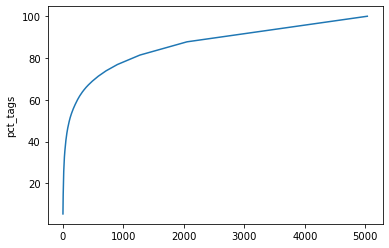

In [10]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_tags'])

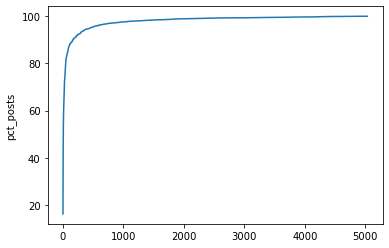

In [11]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_posts'])

In [12]:
df_tags_unique.loc[199, :]

tag               tsql
n_occurence         15
pct_tags       57.5475
n_posts           7275
pct_posts      90.9375
Name: 199, dtype: object

# Modelling

In [13]:
list_top = df_tags_unique.loc[0:199, 'tag']

df_tags = df_tags[list_top]

keep_index = df_tags[df_tags.sum(axis = 1) != 0].index

X = df.loc[keep_index, 'Post']
y = df_tags.loc[keep_index, :]

In [14]:
# Remove '-' from RE_PUNCT in order to adapt the gensim strip_punctuation filter 
#  and conserve words like machine-learning, deep-learning ... 

In [15]:
gsp.RE_PUNCT

re.compile(r'([!"\#\$%\&\'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~])+',
re.UNICODE)

In [16]:
punctuation = r"""!"#$%&'()*+,./:;<=>?@[\]^_`{|}~"""
gsp.RE_PUNCT = re.compile(r'([%s])+' % re.escape(punctuation), re.UNICODE)

In [17]:
gsp.RE_PUNCT

re.compile(r'([!"\#\$%\&\'\(\)\*\+,\./:;<=>\?@\[\\\]\^_`\{\|\}\~])+',
re.UNICODE)

In [18]:
# Define and apply gensim filters
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
#            gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    
    s = s.split()
    
    return s

# Custom transformer using gensim filters
class TextCleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [19]:
Z = ['machine-learning']
TextCleaner().transform(Z)

[['machine-learning']]

In [20]:
data_lemmatized = TextCleaner().transform(X)

# Create Dictionary
id2word = Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [21]:
# Text is in the form of a list of words 
data_lemmatized[55][0:10]

['use',
 'functions',
 'nested',
 'modules',
 'importing',
 'path',
 'wondering',
 'difference',
 'cases',
 'inner']

In [22]:
# Corpus representation counts the frequency of each word in each text 
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 3), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 8), (40, 2), (41, 3), (42, 3), (43, 1), (44, 7), (45, 2), (46, 3), (47, 1), (48, 1), (49, 2), (50, 1), (51, 2), (52, 3), (53, 1)]]


In [23]:
%%time

# Build LDA model
lda_model = LdaMulticore(corpus = corpus, id2word=id2word, num_topics = 15, random_state = 100, 
                         chunksize = 100, passes = 10, per_word_topics = True)

Wall time: 2min 41s


In [24]:
lda_model.print_topics()

[(0,
  '0.017*"error" + 0.017*"file" + 0.015*"amp" + 0.009*"command" + 0.009*"run" + 0.009*"use" + 0.008*"code" + 0.008*"files" + 0.007*"build" + 0.007*"package"'),
 (1,
  '0.052*"div" + 0.045*"class" + 0.017*"html" + 0.015*"button" + 0.014*"function" + 0.013*"form" + 0.012*"text" + 0.012*"input" + 0.011*"value" + 0.011*"type"'),
 (2,
  '0.015*"com" + 0.014*"file" + 0.011*"url" + 0.010*"https" + 0.010*"api" + 0.010*"request" + 0.010*"error" + 0.008*"json" + 0.008*"http" + 0.008*"new"'),
 (3,
  '0.073*"android" + 0.041*"layout" + 0.025*"view" + 0.021*"item" + 0.020*"parent" + 0.018*"app" + 0.015*"child" + 0.014*"text" + 0.014*"height" + 0.013*"widget"'),
 (4,
  '0.032*"int" + 0.020*"std" + 0.015*"amp" + 0.013*"new" + 0.012*"void" + 0.012*"return" + 0.010*"node" + 0.009*"main" + 0.009*"include" + 0.008*"char"'),
 (5,
  '0.014*"float" + 0.013*"object" + 0.012*"double" + 0.011*"counter" + 0.011*"test" + 0.011*"vec" + 0.011*"class" + 0.011*"return" + 0.010*"topic" + 0.010*"context"'),
 (6,


In [25]:
%%time

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = 'c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4933781861288398
Wall time: 11.7 s


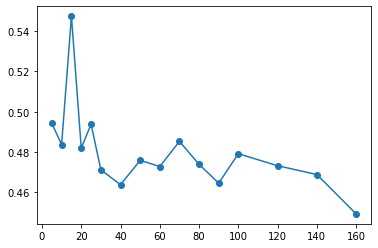

In [22]:
# Evaluate coherence for different values of num_topics
coherence = []
# list_num_topics = range(7, 15)
list_num_topics = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160]

for num_topics in list_num_topics:
    lda_model = LdaMulticore(corpus = corpus, id2word=id2word, num_topics = num_topics, random_state = 100, 
                             chunksize = 100, passes = 10, per_word_topics = True)
    
    coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = 'c_v')

    coherence_lda = coherence_model_lda.get_coherence()
    
    coherence.append(coherence_lda)
    
plt.plot(list_num_topics, coherence, marker = 'o')
plt.savefig('coherence.png', bbox_inches = 'tight')

# Test model in real life conditions

In [26]:
X_test = ['''How to improve model loss and accuracy? 

I'm currently using a Unet model taken from the kaggle starter code, and modified a couple of parameters to train it on the TACO Dataset for litter. Right now, I'm at a loss as to how I should proceed with optimizing my model. I'm experiencing ridiculous amounts of loss and abysmal accuracy, and I'm not entirely sure which parameters would improve my model's accuracy and loss. The TACO dataset has 60 categories (61 including background). Am I doing something wrong? I'm pretty new to this so any references I could read or advice would be much appreciated.

Here is the code for my model:

IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
epochs = 25
validation_steps = val_size
steps_per_epoch = train_size

##Creating the model

initializer = "he_normal"

###Building U-Net Model

##Input Layer
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

##Converting inputs to float
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

##Contraction
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c5)

##Expansion
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c9)

##Output Layer
outputs = tf.keras.layers.Dense(61, activation="softmax")(c9)

##Defining Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

##Compiling Model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

##Training the model
results = model.fit(x = train_gen, 
                    validation_data = val_gen, 
                    steps_per_epoch = steps_per_epoch, 
                    validation_steps = validation_steps, 
                    epochs = epochs, 
                    verbose = True)

And here is the accuracy and loss from the first epoch:

Epoch 1/25
 185/1200 [===>..........................] - ETA: 3:30:04 - loss: 388.0077 - accuracy: 9.0721e-04

I'm currently using tensorboard, modelcheckpoint, and earlystopping for callbacks, but unfortunately I don't know how these will help with optimizing my model. Would a larger number of neurons per layer work?
''']

# real tags = python tensorflow machine-learning keras deep-learning
# https://stackoverflow.com/questions/61927516/how-to-improve-model-loss-and-accuracy

In [27]:
X_test_prep = TextCleaner().transform(X_test)

In [28]:
corpus_test = id2word.doc2bow(X_test_prep[0])

In [29]:
topics_pred = lda_model.get_document_topics(corpus_test)
topics_pred

[(6, 0.022048024),
 (9, 0.01309305),
 (12, 0.010165672),
 (13, 0.80127233),
 (14, 0.15166813)]

In [30]:
lda_tags = []

for i in range(0, lda_model.num_topics):
    
    topic_tags = []
    
    for word, proba in lda_model.show_topic(i, topn = 15):
#         if (list_top.str.contains(word)).sum() >= 1: 
        if (list_top == word).sum() == 1:
            topic_tags.append(word)
    
    lda_tags.append(topic_tags)

In [31]:
lda_tags

[['file'],
 ['class', 'html', 'function', 'input', 'php'],
 ['file', 'api', 'json'],
 ['android'],
 ['string', 'function'],
 ['object', 'class'],
 ['sql'],
 ['java', 'android', 'class'],
 ['function', 'object'],
 ['list', 'function'],
 ['image'],
 ['string', 'class', 'list'],
 ['python', 'file', 'django', 'pygame'],
 ['tensorflow', 'input', 'keras', 'git'],
 ['date', 'time', 'filter', 'datetime']]

In [32]:
tags_pred = []

for topic_nb, proba in topics_pred:
    tags_pred.extend(lda_tags[topic_nb])

# Remove potential duplicates
tags_pred = list(set(tags_pred))

In [33]:
tags_pred

['filter',
 'sql',
 'tensorflow',
 'file',
 'pygame',
 'git',
 'input',
 'python',
 'date',
 'keras',
 'list',
 'django',
 'time',
 'datetime',
 'function']

In [148]:
list_top

0               python
1           javascript
2                 java
3                   c#
4                    r
            ...       
195              shiny
196    azure-functions
197        material-ui
198                npm
199               tsql
Name: tag, Length: 200, dtype: object

# Visualize LDA results using pyLDAvis

Warning : pyLDAvis bug in Jupyter Lab causes it to hide toolbar buttons (cf. https://github.com/bmabey/pyLDAvis/issues/162). 

In [34]:
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
 
LDAvis_prepared